# Bike Sharing: Predicción de demanda horaria

Diego Pérez Tapia<br>
ROL: 201173045-3

### a)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

dftrain = pd.read_csv("bike_sharing_train.csv")
dfval = pd.read_csv("bike_sharing_val.csv")
dftest = pd.read_csv("bike_sharing_test.csv")
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df = df.drop("Unnamed: 0", axis=1) # Drop index column
df["hour"] = pd.to_datetime(df["datetime"]).apply(lambda x: x.strftime("%H"))
df["hour"] = pd.to_numeric(df["hour"])
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


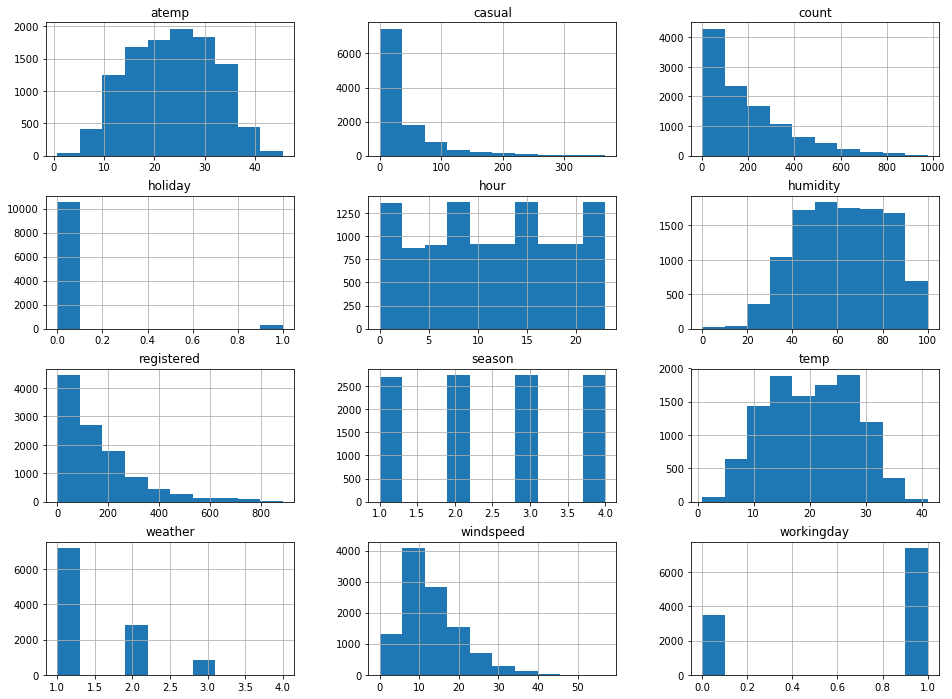

In [72]:
h = df.hist(figsize=(16,12))

### b)

In [2]:
def eval_bikemodel(y, y_,convertExp=False):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [4]:
# Feature selection
Xdf = df.ix[:,["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","hour"]]
Ydf = df.ix[:,"count"]
# Train Val Test Split
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

(6562, 9) (6562,) (2177, 9) (2177,) (2147, 9) (2147,)


In [5]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, Y_train)
train_score = model.score(X_train, Y_train)
test_score = model.score(X_test, Y_test)
train_kaggle = eval_bikemodel(Y_train, model.predict(X_train))
test_kaggle = eval_bikemodel(Y_test, model.predict(X_test))

print("Train scores\n\nR^2 coefficient = {:<20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:<20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient = 0.9991929779484634  
Kaggle score = 0.028516283291769754


Test scores

R^2 coefficient = 0.7048983586718623  
Kaggle score = 0.571341725533612   


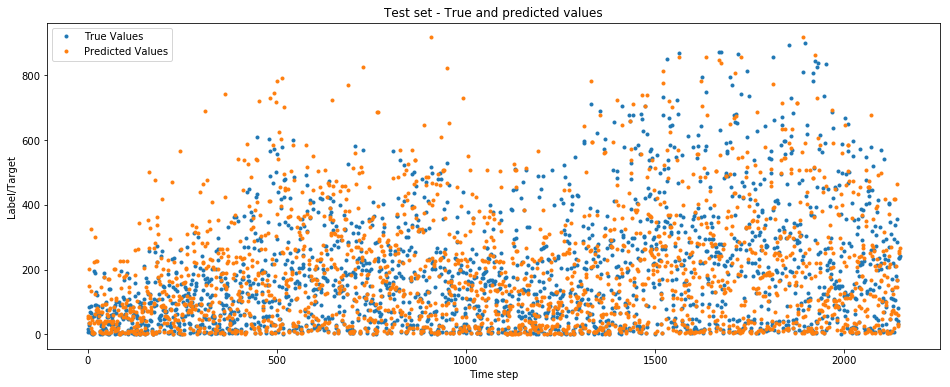

In [6]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1)
f.set_size_inches(16,6)
ax.plot(np.arange(0, Y_test.size), Y_test,".", label="True Values")
ax.plot(np.arange(0, Y_test.size), model.predict(X_test), ".", label="Predicted Values")
ax.set_xlabel("Time step")
ax.set_ylabel("Label/Target")
ax.set_title("Test set - True and predicted values")
ax.legend()
plt.show()

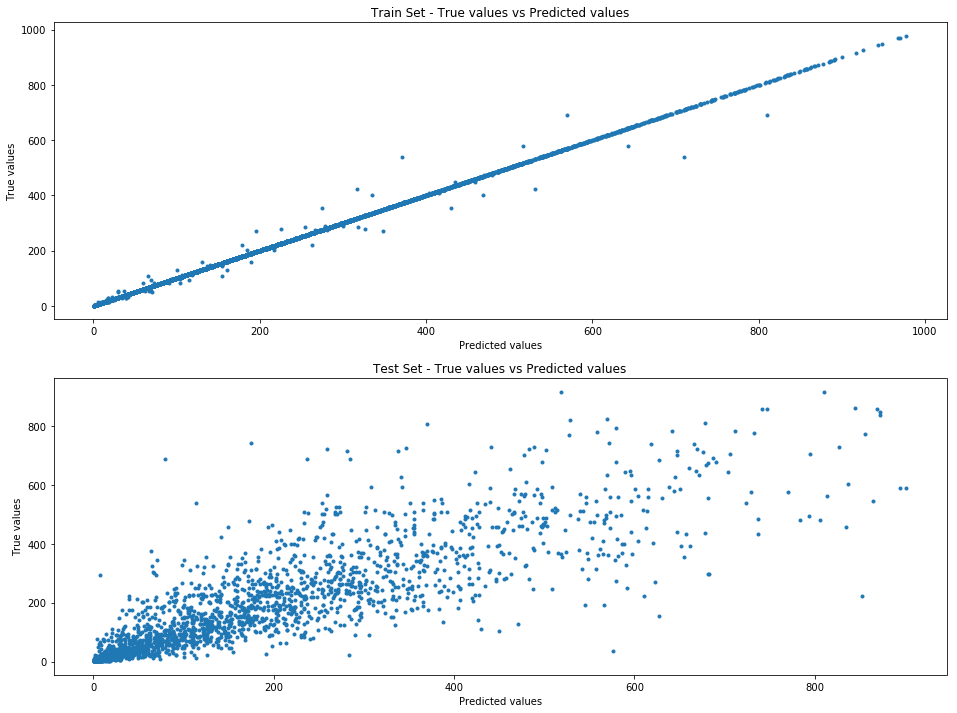

In [78]:
f, ax = plt.subplots(2,1)
f.set_size_inches(16,12)
ax[0].plot(Y_train, model.predict(X_train), ".")
ax[0].set_title("Train Set - True values vs Predicted values")
ax[0].set_ylabel("True values")
ax[0].set_xlabel("Predicted values")
ax[1].plot(Y_test, model.predict(X_test), ".")
ax[1].set_title("Test Set - True values vs Predicted values")
ax[1].set_ylabel("True values")
ax[1].set_xlabel("Predicted values")
plt.show()

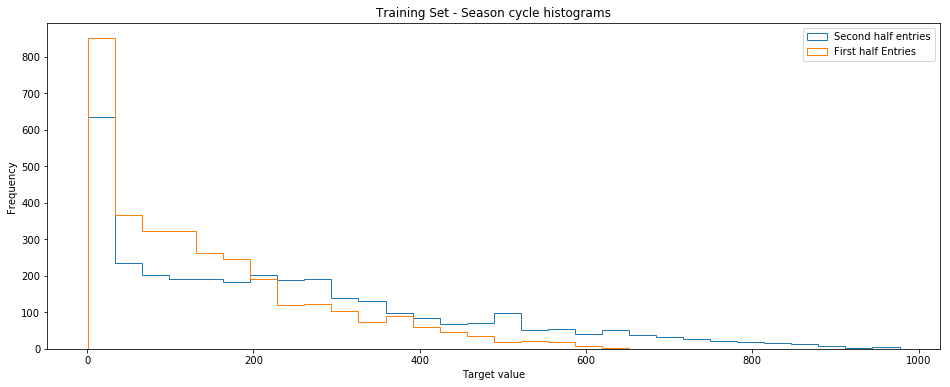

In [97]:
f, ax = plt.subplots()
f.set_size_inches(16,6)
_, bins, _ = ax.hist(Y_train[Y_train.size//2:], bins=30, histtype="step", label="Second half entries")
ax.hist(Y_train[:Y_train.size//2], bins=bins, histtype="step", label="First half Entries")
ax.set_ylabel("Frequency")
ax.set_xlabel("Target value")
ax.set_title("Training Set - Season cycle histograms")
ax.legend()
plt.show()

### c)

In [178]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

x_tr = np.concatenate((X_train, X_val))
y_tr = np.concatenate((Y_train, Y_val))

model = DecisionTreeRegressor()
depths = [2,5,10,20,40]
splitters = ["best", "random"]

param_grid = dict(max_depth=depths,
                   splitter=splitters)

scorer = make_scorer(eval_bikemodel, greater_is_better=False)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, verbose=0, cv=10)
results = grid.fit(x_tr, y_tr)

In [179]:
results.best_params_

{'max_depth': 10, 'splitter': 'best'}

In [180]:
results.best_score_*-1

0.51807412296910571

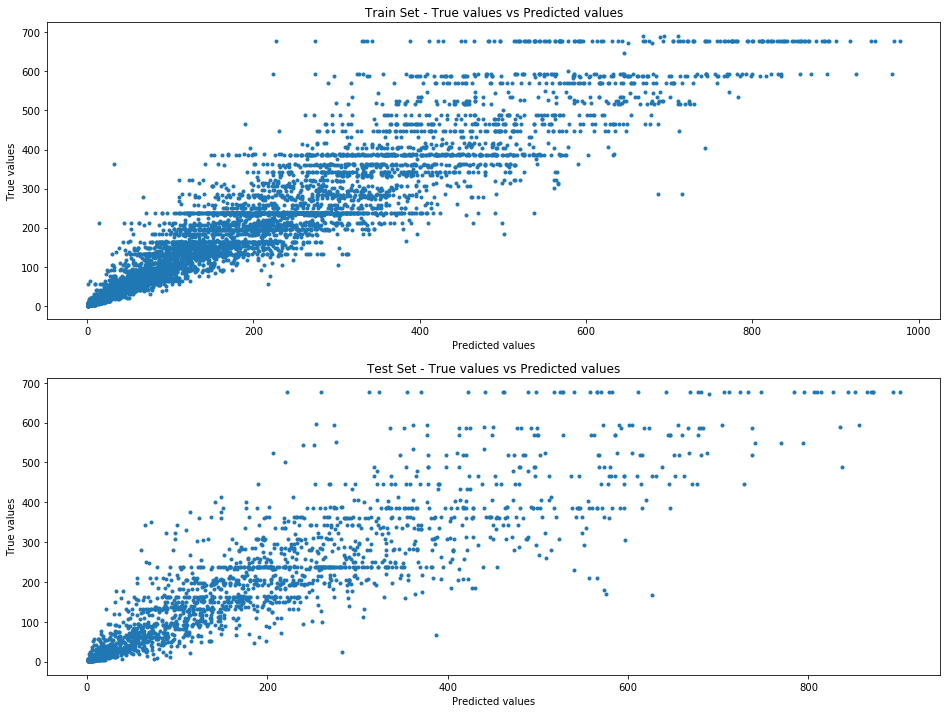

In [181]:
f, ax = plt.subplots(2,1)
f.set_size_inches(16,12)
ax[0].plot(Y_train, results.best_estimator_.predict(X_train), ".")
ax[0].set_title("Train Set - True values vs Predicted values")
ax[0].set_ylabel("True values")
ax[0].set_xlabel("Predicted values")
ax[1].plot(Y_test, results.best_estimator_.predict(X_test), ".")
ax[1].set_title("Test Set - True values vs Predicted values")
ax[1].set_ylabel("True values")
ax[1].set_xlabel("Predicted values")
plt.show()

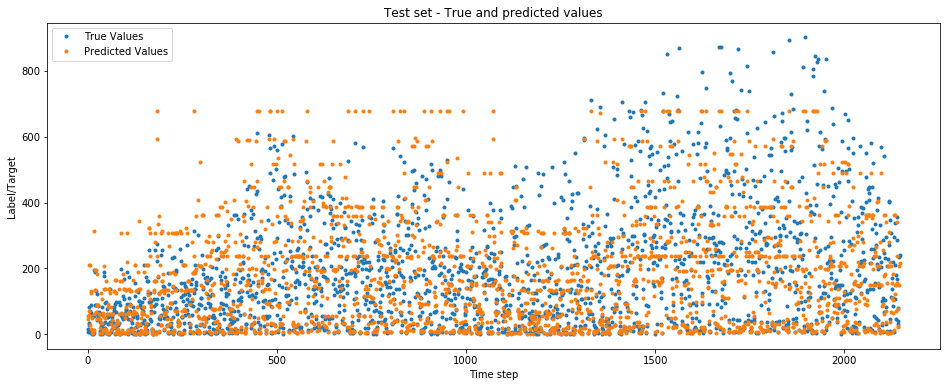

In [183]:
f, ax = plt.subplots(1)
f.set_size_inches(16,6)
ax.plot(np.arange(0, Y_test.size), Y_test,".", label="True Values")
ax.plot(np.arange(0, Y_test.size), results.best_estimator_.predict(X_test), ".", label="Predicted Values")
ax.set_xlabel("Time step")
ax.set_ylabel("Label/Target")
ax.set_title("Test set - True and predicted values")
ax.legend()
plt.show()

### d)

In [326]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, np.log1p(Y_train))
train_score = model.score(X_train, np.log1p(Y_train))
test_score = model.score(X_test, np.log1p(Y_test))
train_kaggle = eval_bikemodel(Y_train, np.exp(model.predict(X_train)))
test_kaggle = eval_bikemodel(Y_test, np.exp(model.predict(X_test)))

print("Train scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient =   0.9416140793549204
Kaggle score = 0.3506871804273076  


Test scores

R^2 coefficient =   0.8485092645799013
Kaggle score = 0.5409777663945274  


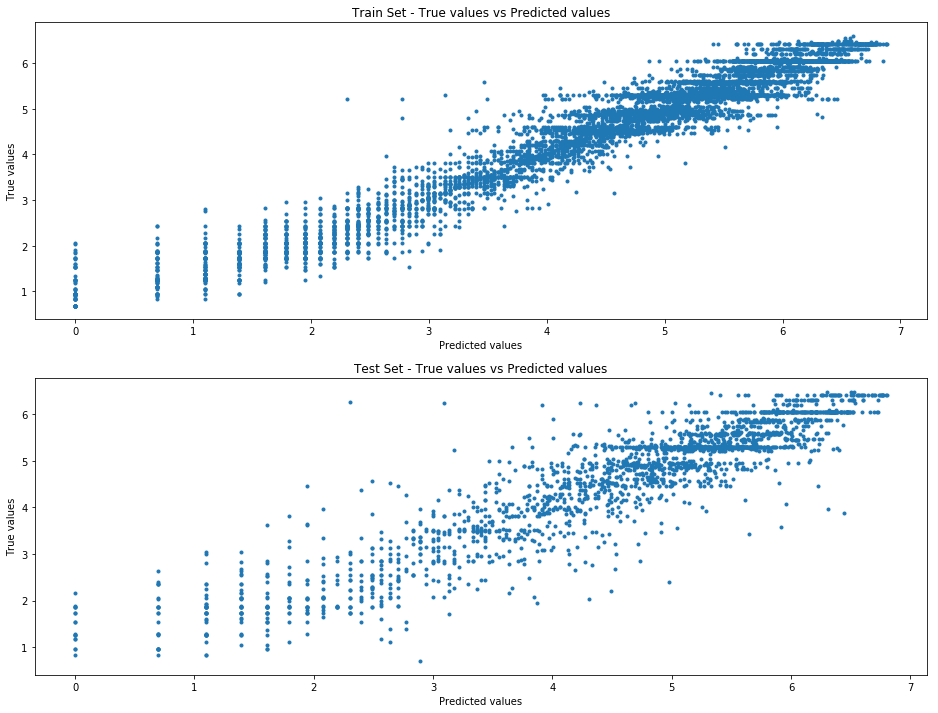

In [327]:
f, ax = plt.subplots(2,1)
f.set_size_inches(16,12)
ax[0].plot(np.log(Y_train), model.predict(X_train), ".")
ax[0].set_title("Train Set - True values vs Predicted values")
ax[0].set_ylabel("True values")
ax[0].set_xlabel("Predicted values")
ax[1].plot(np.log(Y_test), model.predict(X_test), ".")
ax[1].set_title("Test Set - True values vs Predicted values")
ax[1].set_ylabel("True values")
ax[1].set_xlabel("Predicted values")
plt.show()

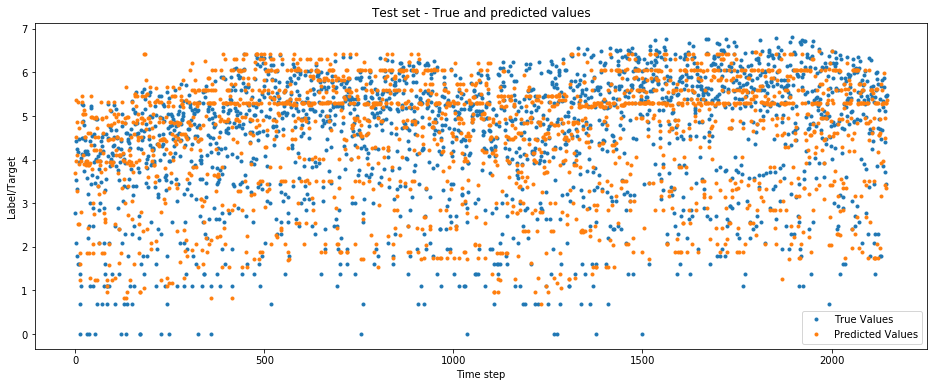

In [328]:
f, ax = plt.subplots(1)
f.set_size_inches(16,6)
ax.plot(np.arange(0, Y_test.size), np.log(Y_test),".", label="True Values")
ax.plot(np.arange(0, Y_test.size), model.predict(X_test), ".", label="Predicted Values")
ax.set_xlabel("Time step")
ax.set_ylabel("Label/Target")
ax.set_title("Test set - True and predicted values")
ax.legend()
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
x_tr_s = scaler.fit_transform(X_train)
x_te_s = scaler.transform(X_test)

model = DecisionTreeRegressor(max_depth=10)
model.fit(x_tr_s, Y_train)
train_score = model.score(x_tr_s, Y_train)
test_score = model.score(x_te_s, Y_test)
train_kaggle = eval_bikemodel(Y_train, model.predict(x_tr_s))
test_kaggle = eval_bikemodel(Y_test, model.predict(x_te_s))

print("Train scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient =   0.8765331969641229
Kaggle score = 0.3386348349881588  


Test scores

R^2 coefficient =   0.7699254433984156
Kaggle score = 0.5160983121130609  


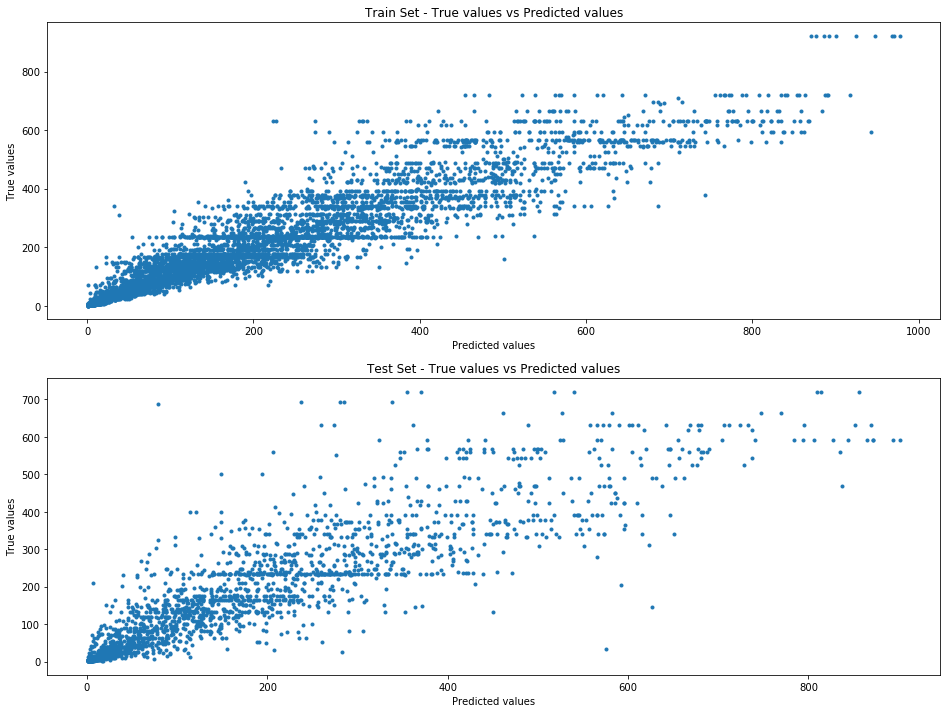

In [264]:
f, ax = plt.subplots(2,1)
f.set_size_inches(16,12)
ax[0].plot(Y_train, model.predict(x_tr_s), ".")
ax[0].set_title("Train Set - True values vs Predicted values")
ax[0].set_ylabel("True values")
ax[0].set_xlabel("Predicted values")
ax[1].plot(Y_test, model.predict(x_te_s), ".")
ax[1].set_title("Test Set - True values vs Predicted values")
ax[1].set_ylabel("True values")
ax[1].set_xlabel("Predicted values")
plt.show()

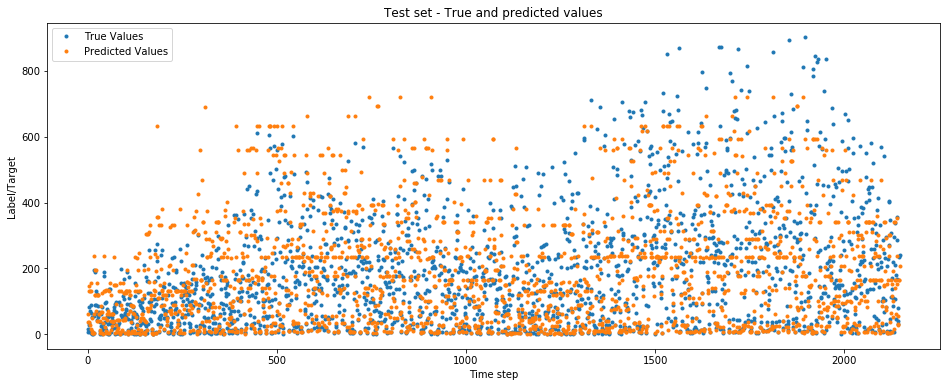

In [265]:
f, ax = plt.subplots(1)
f.set_size_inches(16,6)
ax.plot(np.arange(0, Y_test.size), Y_test,".", label="True Values")
ax.plot(np.arange(0, Y_test.size), model.predict(x_te_s), ".", label="Predicted Values")
ax.set_xlabel("Time step")
ax.set_ylabel("Label/Target")
ax.set_title("Test set - True and predicted values")
ax.legend()
plt.show()

In [351]:
df["cday"] = pd.to_datetime(df["datetime"]).dt.dayofweek #0:lunes,6:domingo
df["cday"] = df["cday"].astype("category")
Xdf = df.ix[:,["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","hour","cday"]]
# Train Val Test Split
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values

Xdf.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,23.000000


In [352]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, Y_train)
train_score = model.score(X_train, Y_train)
test_score = model.score(X_test, Y_test)
train_kaggle = eval_bikemodel(Y_train, model.predict(X_train))
test_kaggle = eval_bikemodel(Y_test, model.predict(X_test))

print("Train scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient =   0.8775087096060157
Kaggle score = 0.3362689682698025  


Test scores

R^2 coefficient =   0.7824698454615229
Kaggle score = 0.5039451423123051  


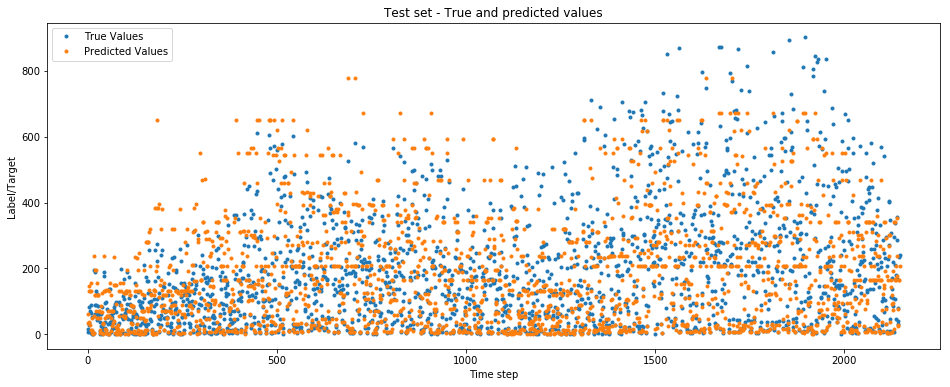

In [331]:
f, ax = plt.subplots(1)
f.set_size_inches(16,6)
ax.plot(np.arange(0, Y_test.size), Y_test,".", label="True Values")
ax.plot(np.arange(0, Y_test.size), model.predict(X_test), ".", label="Predicted Values")
ax.set_xlabel("Time step")
ax.set_ylabel("Label/Target")
ax.set_title("Test set - True and predicted values")
ax.legend()
plt.show()

In [353]:
scaler = StandardScaler()
x_tr_s = scaler.fit_transform(X_train)
x_te_s = scaler.transform(X_test)
y_tr_log = np.log1p(Y_train)
y_te_log = np.log1p(Y_test)

model = DecisionTreeRegressor(max_depth=10)
model.fit(x_tr_s, y_tr_log)
train_score = model.score(x_tr_s, y_tr_log)
test_score = model.score(x_te_s, y_te_log)
train_kaggle = eval_bikemodel(np.exp(y_tr_log), np.exp(model.predict(x_tr_s)))
test_kaggle = eval_bikemodel(np.exp(y_te_log), np.exp(model.predict(x_te_s)))

print("Train scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient =   0.9481596824753721
Kaggle score = 0.3135764666047128  


Test scores

R^2 coefficient =   0.8571807184979277
Kaggle score = 0.5079139420920651  


/home/diego/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [354]:
Xdf = df.ix[:,["season","holiday","workingday","atemp","humidity","windspeed","hour","cday"]]
# Train Val Test Split
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values

Xdf.describe()

,season,holiday,workingday,atemp,humidity,windspeed,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,23.655084,61.886460,12.799395,11.541613
std,1.116174,0.166599,0.466159,8.474601,19.245033,8.164537,6.915838
min,1.000000,0.000000,0.000000,0.760000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,16.665000,47.000000,7.001500,6.000000
50%,3.000000,0.000000,1.000000,24.240000,62.000000,12.998000,12.000000
75%,4.000000,0.000000,1.000000,31.060000,77.000000,16.997900,18.000000
max,4.000000,1.000000,1.000000,45.455000,100.000000,56.996900,23.000000


In [356]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, Y_train)
train_score = model.score(X_train, Y_train)
test_score = model.score(X_test, Y_test)
train_kaggle = eval_bikemodel(Y_train, model.predict(X_train))
test_kaggle = eval_bikemodel(Y_test, model.predict(X_test))

print("Train scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient =   0.8683929205612559
Kaggle score = 0.35136687125692107 


Test scores

R^2 coefficient =   0.7629926569264349
Kaggle score = 0.519999195583753   


In [125]:
dftrain = pd.read_csv("bike_sharing_train.csv")
dfval = pd.read_csv("bike_sharing_val.csv")
dftest = pd.read_csv("bike_sharing_test.csv")
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df = df.drop("Unnamed: 0", axis=1)
df = pd.concat([dftrain,dfval,dftest])
dt = pd.to_datetime(df['datetime']).dt

#df["day"] = pd.to_numeric(dt.day).apply(lambda x: float(x))
#df["month"] = pd.to_numeric(dt.month)
df["year"] = pd.to_numeric(dt.year)
df["hour"] = pd.to_numeric(dt.hour)
df["dow"] = pd.to_numeric(dt.dayofweek)
df["woy"] = pd.to_numeric(dt.weekofyear)

Xdf = df.loc[:,["season","holiday","workingday","weather","temp","atemp",
                "humidity","windspeed","hour","year","dow","woy"]]
Ydf = df.loc[:,"count"]

# Train Val Test Split
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values

In [120]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, Y_train)
train_score = model.score(X_train, Y_train)
test_score = model.score(X_test, Y_test)
train_kaggle = eval_bikemodel(Y_train, model.predict(X_train))
test_kaggle = eval_bikemodel(Y_test, model.predict(X_test))

print("Train scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient =   0.9395822562386722
Kaggle score = 0.26708713518856536 


Test scores

R^2 coefficient =   0.8963193953576506
Kaggle score = 0.41936435325396043 


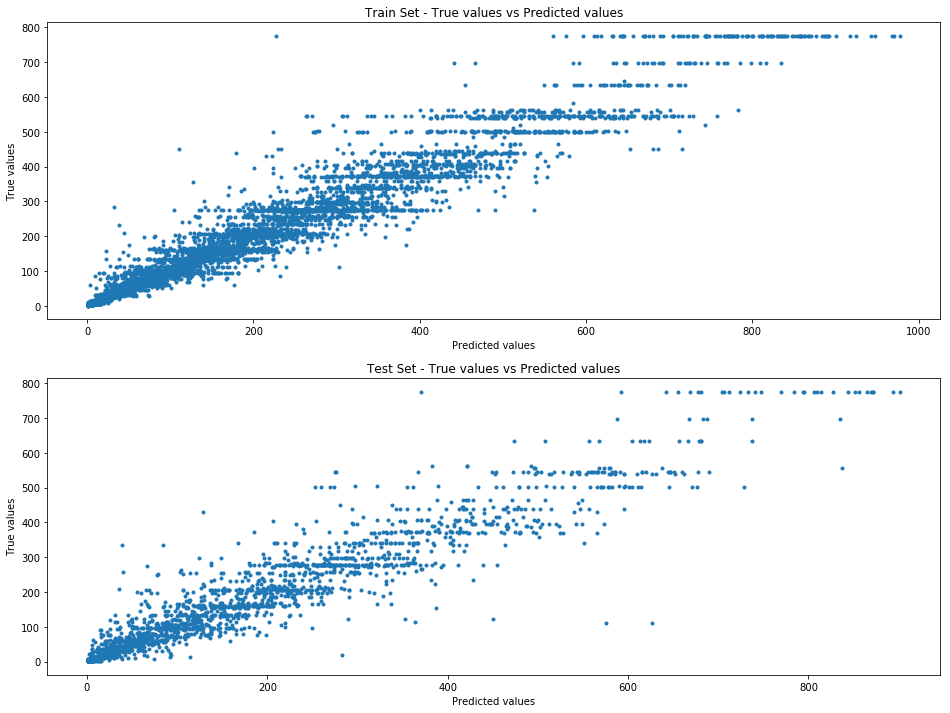

In [121]:
f, ax = plt.subplots(2,1)
f.set_size_inches(16,12)
ax[0].plot(Y_train, model.predict(X_train), ".")
ax[0].set_title("Train Set - True values vs Predicted values")
ax[0].set_ylabel("True values")
ax[0].set_xlabel("Predicted values")
ax[1].plot(Y_test, model.predict(X_test), ".")
ax[1].set_title("Test Set - True values vs Predicted values")
ax[1].set_ylabel("True values")
ax[1].set_xlabel("Predicted values")
plt.show()

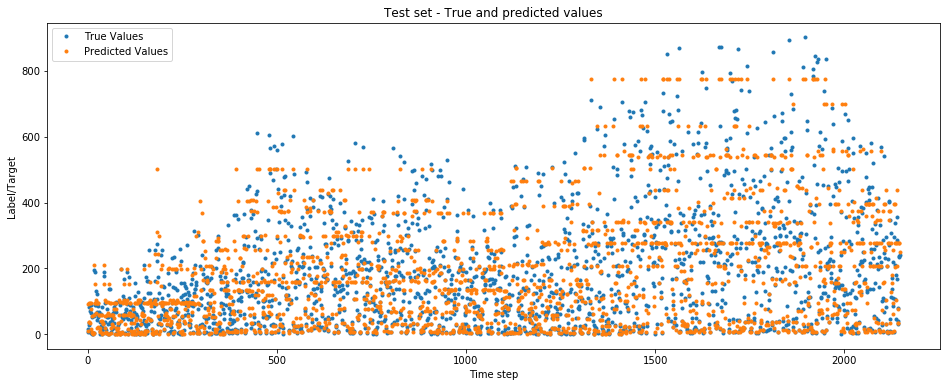

In [122]:
f, ax = plt.subplots(1)
f.set_size_inches(16,6)
ax.plot(np.arange(0, Y_test.size), Y_test,".", label="True Values")
ax.plot(np.arange(0, Y_test.size), model.predict(X_test), ".", label="Predicted Values")
ax.set_xlabel("Time step")
ax.set_ylabel("Label/Target")
ax.set_title("Test set - True and predicted values")
ax.legend()
plt.show()

### e) SVM

In [7]:
from sklearn.svm import SVR

In [8]:
dftrain = pd.read_csv("bike_sharing_train.csv")
dfval = pd.read_csv("bike_sharing_val.csv")
dftest = pd.read_csv("bike_sharing_test.csv")
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df = df.drop("Unnamed: 0", axis=1)
df = pd.concat([dftrain,dfval,dftest])
dt = pd.to_datetime(df['datetime']).dt

df["day"] = pd.to_numeric(dt.day)
#df["month"] = pd.to_numeric(dt.month)
df["year"] = pd.to_numeric(dt.year)
df["hour"] = pd.to_numeric(dt.hour)
df["dow"] = pd.to_numeric(dt.dayofweek)
df["woy"] = pd.to_numeric(dt.weekofyear)

Xdf = df.loc[:,["season","holiday","workingday","weather","atemp",
                "humidity","windspeed","hour","day","year"]]
Ydf = df.loc[:,"count"]

Xdf_enc = pd.get_dummies(Xdf,columns=["season","weather","hour","day","year"])

# Train Val Test Split
X_train = Xdf_enc[0:ntrain].values
X_val = Xdf_enc[ntrain:nval].values
X_test = Xdf_enc[nval:].values

Xdf_enc.head()

,holiday,workingday,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,...,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,year_2011,year_2012
0,0,0,14.395,75,0.0000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,14.395,75,0.0000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,12.880,75,6.0032,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,13.635,80,0.0000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,12.880,86,0.0000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [147]:
scalerX = StandardScaler()
x_tr_s = scalerX.fit_transform(X_train)
x_val_s = scalerX.transform(X_val)
x_t_s = scalerX.transform(X_test)

model = SVR()
model.fit(x_tr_s, Y_train)
train_score = model.score(x_tr_s, Y_train)
test_score = model.score(x_t_s, Y_test)
train_kaggle = eval_bikemodel(Y_train, model.predict(x_tr_s))
test_kaggle = eval_bikemodel(Y_test, model.predict(x_t_s))

print("Train scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient =  0.26494520581926884
Kaggle score = 1.1514884353436832  


Test scores

R^2 coefficient =   0.2679679321446855
Kaggle score = 1.1356204354371506  


In [10]:
from sklearn.preprocessing import StandardScaler

In [12]:
scalerX = StandardScaler()
x_tr_s = scalerX.fit_transform(X_train)
x_val_s = scalerX.transform(X_val)
x_t_s = scalerX.transform(X_test)
y_tr_log = np.log1p(Y_train)
y_t_log = np.log1p(Y_test)

model = SVR()
model.fit(x_tr_s, y_tr_log)
train_score = model.score(x_tr_s, y_tr_log)
test_score = model.score(x_t_s, y_t_log)
train_kaggle = eval_bikemodel(np.exp(y_tr_log), np.exp(model.predict(x_tr_s)))
test_kaggle = eval_bikemodel(np.exp(y_t_log), np.exp(model.predict(x_t_s)))

print("Train scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}\n\n".format(train_score, train_kaggle))
print("Test scores\n\nR^2 coefficient = {:>20}\nKaggle score = {:<20}".format(test_score, test_kaggle))

Train scores

R^2 coefficient =   0.9676199241551484
Kaggle score = 0.23859027730824564 


Test scores

R^2 coefficient =   0.9284013696302051
Kaggle score = 0.3542768314223912  
